In [6]:
import sys
import os
from pathlib import Path

# Handling the scenario where __file__ might not be defined
if '__file__' in globals():
    # If __file__ is defined, use it to get the current directory
    current_dir = Path(os.path.dirname(os.path.abspath(__file__)))
else:
    # If __file__ is not defined, fall back to the current working directory
    current_dir = Path(os.getcwd())

# Calculate the parent directory
parent_dir = current_dir.parent

# Append the parent directory to sys.path
sys.path.append(str(parent_dir))


In [7]:
import geopandas as gpd
import momepy
import networkx as nx
import graph_tool.all as gt
import pandas as pd
import matplotlib
import itertools
from shapely.geometry import LineString, point
from shapely.wkt import loads
from tqdm import tqdm
import numpy as np
from dask.distributed import Client, LocalCluster
from dask import delayed
import dask
import math
import concurrent.futures
import matplotlib.pyplot as plt
import osmnx as ox

In [8]:
local_crs = 27700
place = "test"
lat = 55.86421405612109
lng = -4.251846930489373
country = "UK"
crs=4326
radius=1

In [10]:
streets = gpd.read_parquet(f"../output/{place}/streets_p2.pq").to_crs(local_crs).reset_index(drop=True)

In [11]:
streets

geometry
0       LINESTRING (525420.419 180495.642, 525421.734 ...
1       LINESTRING (525405.142 180548.597, 525414.424 ...
2       LINESTRING (525420.419 180495.642, 525425.592 ...
3       LINESTRING (525467.280 180513.066, 525463.776 ...
4       LINESTRING (525360.702 180475.843, 525386.480 ...
...                                                   ...
312637  LINESTRING (543535.071 178167.014, 543534.854 ...
312638  LINESTRING (530761.466 139500.553, 530729.921 ...
312639  LINESTRING (530791.729 139555.274, 530801.368 ...
312640  LINESTRING (530739.217 139548.667, 530748.953 ...
312641  LINESTRING (530786.696 139567.686, 530746.166 ...

[312642 rows x 1 columns]

In [12]:
daskCluster = LocalCluster(threads_per_worker=2,
                n_workers=8, memory_limit='100GB')

client = Client(daskCluster)

client

2024-01-11 17:06:42,899 - distributed.nanny.memory - WARNING - Ignoring provided memory limit 100GB due to system memory limit of 31.31 GiB
2024-01-11 17:06:42,902 - distributed.nanny.memory - WARNING - Ignoring provided memory limit 100GB due to system memory limit of 31.31 GiB
2024-01-11 17:06:42,905 - distributed.nanny.memory - WARNING - Ignoring provided memory limit 100GB due to system memory limit of 31.31 GiB
2024-01-11 17:06:42,908 - distributed.nanny.memory - WARNING - Ignoring provided memory limit 100GB due to system memory limit of 31.31 GiB
2024-01-11 17:06:42,910 - distributed.nanny.memory - WARNING - Ignoring provided memory limit 100GB due to system memory limit of 31.31 GiB
2024-01-11 17:06:42,913 - distributed.nanny.memory - WARNING - Ignoring provided memory limit 100GB due to system memory limit of 31.31 GiB
2024-01-11 17:06:42,916 - distributed.nanny.memory - WARNING - Ignoring provided memory limit 100GB due to system memory limit of 31.31 GiB
2024-01-11 17:06:42,

<Client: 'tcp://127.0.0.1:40875' processes=8 threads=16, memory=250.47 GiB>

In [13]:
streets["id"] = streets.index

In [14]:
# Create a pandas dataframe from the multigraph
primal = momepy.gdf_to_nx(streets, approach='primal')

In [15]:
nodes, edges, sw = momepy.nx_to_gdf(primal, points=True, lines=True,
                                    spatial_weights=True)

/home/virgilxw/miniforge3/envs/processor/lib/python3.12/site-packages/libpysal/weights/weights.py:224: UserWarning: The weights matrix is not fully connected: 
 There are 546 disconnected components.
  warnings.warn(message)


In [16]:
edges

geometry      id      mm_len  \
0       LINESTRING (525420.419 180495.642, 525421.734 ...       0   97.726992   
1       LINESTRING (525405.142 180548.597, 525414.424 ...       1   55.114502   
2       LINESTRING (525420.419 180495.642, 525425.592 ...       2   52.269297   
3       LINESTRING (525467.280 180513.066, 525463.776 ...       3   52.237226   
4       LINESTRING (525360.702 180475.843, 525386.480 ...       4   62.934488   
...                                                   ...     ...         ...   
312637  LINESTRING (560016.304 173128.231, 560007.199 ...  312627   71.277351   
312638  LINESTRING (559962.500 173645.435, 560006.063 ...  312631   49.130611   
312639  LINESTRING (559962.500 173645.435, 559936.212 ...  312632  161.762019   
312640  LINESTRING (530761.466 139500.553, 530729.921 ...  312638   49.663778   
312641  LINESTRING (530791.729 139555.274, 530801.368 ...  312639  103.586551   

        node_start  node_end  
0                0         1  
1                0         2  
2                0         3  
3                0         3  
4                0         4  
...            ...       ...  
312637      255334    255336  
312638      255339    255340  
312639      255339    255340  
312640      255344    255345  
312641      255344    255346  

[312642 rows x 5 columns]

In [17]:
edges = edges.drop_duplicates(subset='geometry')

In [18]:
nodes = nodes.drop_duplicates(subset='geometry')

In [19]:
continuity = momepy.COINS(edges)
stroke_gdf = continuity.stroke_gdf()

KeyboardInterrupt: 

In [ ]:
stroke_gdf.to_parquet(f"../output/{place}/stroke_gdf.pq")

In [ ]:
vertID_dict = {}

In [ ]:
counter = itertools.count()

for node in primal.nodes():
    id = next(counter)
    primal.nodes[node]['vertID'] = id
    vertID_dict[id] = node

In [ ]:
inverted_vertID_dict = {value: key for key, value in vertID_dict.items()}

# Street Network Shapes

In [ ]:
edg_lin = momepy.Linearity(streets)
streets['linearity'] = edg_lin.series

## Node Degree

In [ ]:
degree = dict(nx.degree(primal))
nx.set_node_attributes(primal, degree, "node_degree")

In [ ]:
primal = momepy.node_degree(primal, name='node_degree')

In [ ]:
n, e, s = momepy.nx_to_gdf(primal, points=True, lines=True,
                                    spatial_weights=True)

/home/virgilxw/miniforge3/envs/processor/lib/python3.12/site-packages/libpysal/weights/weights.py:224: UserWarning: The weights matrix is not fully connected: 
 There are 24 disconnected components.
  warnings.warn(message)


In [ ]:
nodes["node_degree"] = n["node_degree"]

# Meshedness + clustering

Eucledean Dist

In [ ]:
## validation to networkx
graph = momepy.gdf_to_nx(streets)

graph = momepy.clustering(graph, name='clustering')

graph = momepy.meshedness(graph, radius=500, name='meshedness_eucl_500', distance='mm_len')

graph = momepy.nx_to_gdf(graph, points=True, lines=False, spatial_weights=False)

100%|██████████| 13752/13752 [00:26<00:00, 509.45it/s]


In [ ]:
nodes["meshedness_eucl_500"] = graph["meshedness_eucl_500"]
nodes["clustering"] = graph["clustering"]

/home/virgilxw/miniforge3/envs/processor/lib/python3.12/site-packages/mapclassify/classifiers.py:255: UserWarning: Not enough unique values in array to form 15 classes. Setting k to 5.
  warnings.warn(


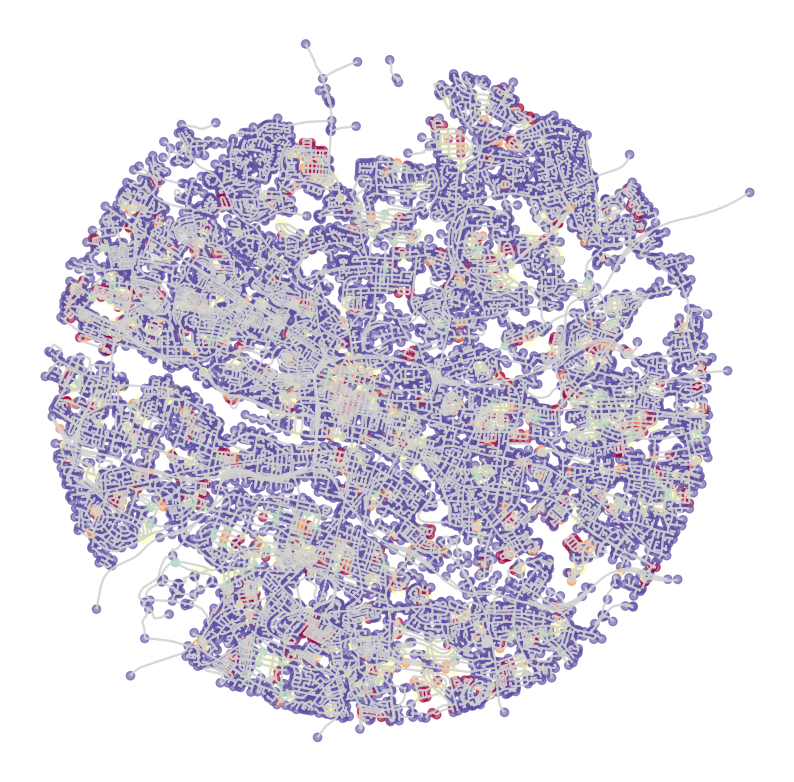

In [ ]:
f, ax = plt.subplots(figsize=(10, 10))
# Plot nodes with a higher zorder
nodes.plot(ax=ax, column='clustering', cmap='Spectral_r', scheme='quantiles', k=15, alpha=0.6)
streets.plot(ax=ax, color='lightgrey', alpha=0.5, zorder=1)
ax.set_axis_off()
plt.show()

Topological Distance

In [ ]:
## validation to networkx
graph = momepy.gdf_to_nx(streets)

graph = momepy.meshedness(graph, radius=5, name='meshedness_topo_5')

graph = momepy.nx_to_gdf(graph, points=True, lines=False, spatial_weights=False)

100%|██████████| 13752/13752 [00:18<00:00, 734.10it/s] 


In [ ]:
nodes["meshedness_topo_5"] = graph["meshedness_topo_5"]

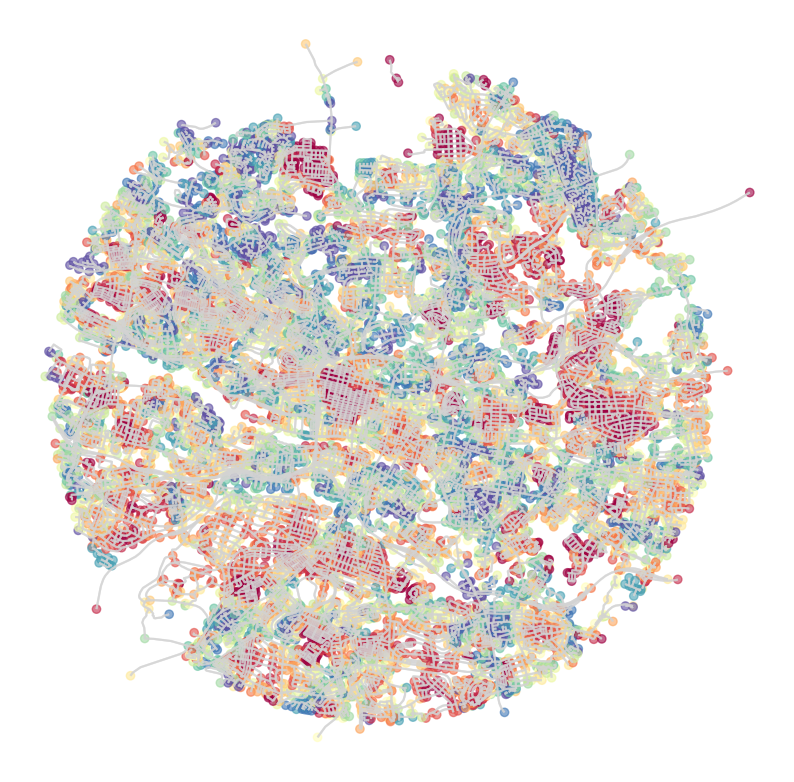

In [ ]:
f, ax = plt.subplots(figsize=(10, 10))
# Plot nodes with a higher zorder
nodes.plot(ax=ax, column="meshedness_topo_5", cmap='Spectral_r', scheme='quantiles', k=15, alpha=0.6)
streets.plot(ax=ax, color='lightgrey', alpha=0.5, zorder=1)
ax.set_axis_off()
plt.show()


# Multiple Centrality Analysis

## Closeness Centrality

### Closeness centrality

Closeness centrality could be simplified as the average distance to every other node from each node. As such, it can be measured on the whole network (Global Closeness Centrality) or within a certain limit only (Local Closeness Centrality). 

#### Local closeness
To measure local `closeness_centrality` we need to specify a radius (how far we should go from each node). We can use topological distance (e.g. 5 steps, then radius=5) or metric distance (e.g. 400 metres) - then radius=400 and distance=length of each segment saved as a parameter of each edge. By default, momepy saves length as `mm_len`. 

The weight parameter is used for centrality calculation. Again, we can use metric weight (using the same attribute as above) or no weight (weight=None) at all. Or any other attribute we wish.

In [ ]:
local_closeness_clustering = momepy.closeness_centrality(primal, radius=400, name='closeness400', distance='mm_len', weight='mm_len')

100%|██████████| 13752/13752 [00:17<00:00, 775.52it/s] 


In [ ]:
local_closeness_clustering = momepy.nx_to_gdf(local_closeness_clustering)
local_closeness_clustering = local_closeness_clustering[0]

In [ ]:
nodes["closeness_clustering_400m"] = local_closeness_clustering["closeness400"]

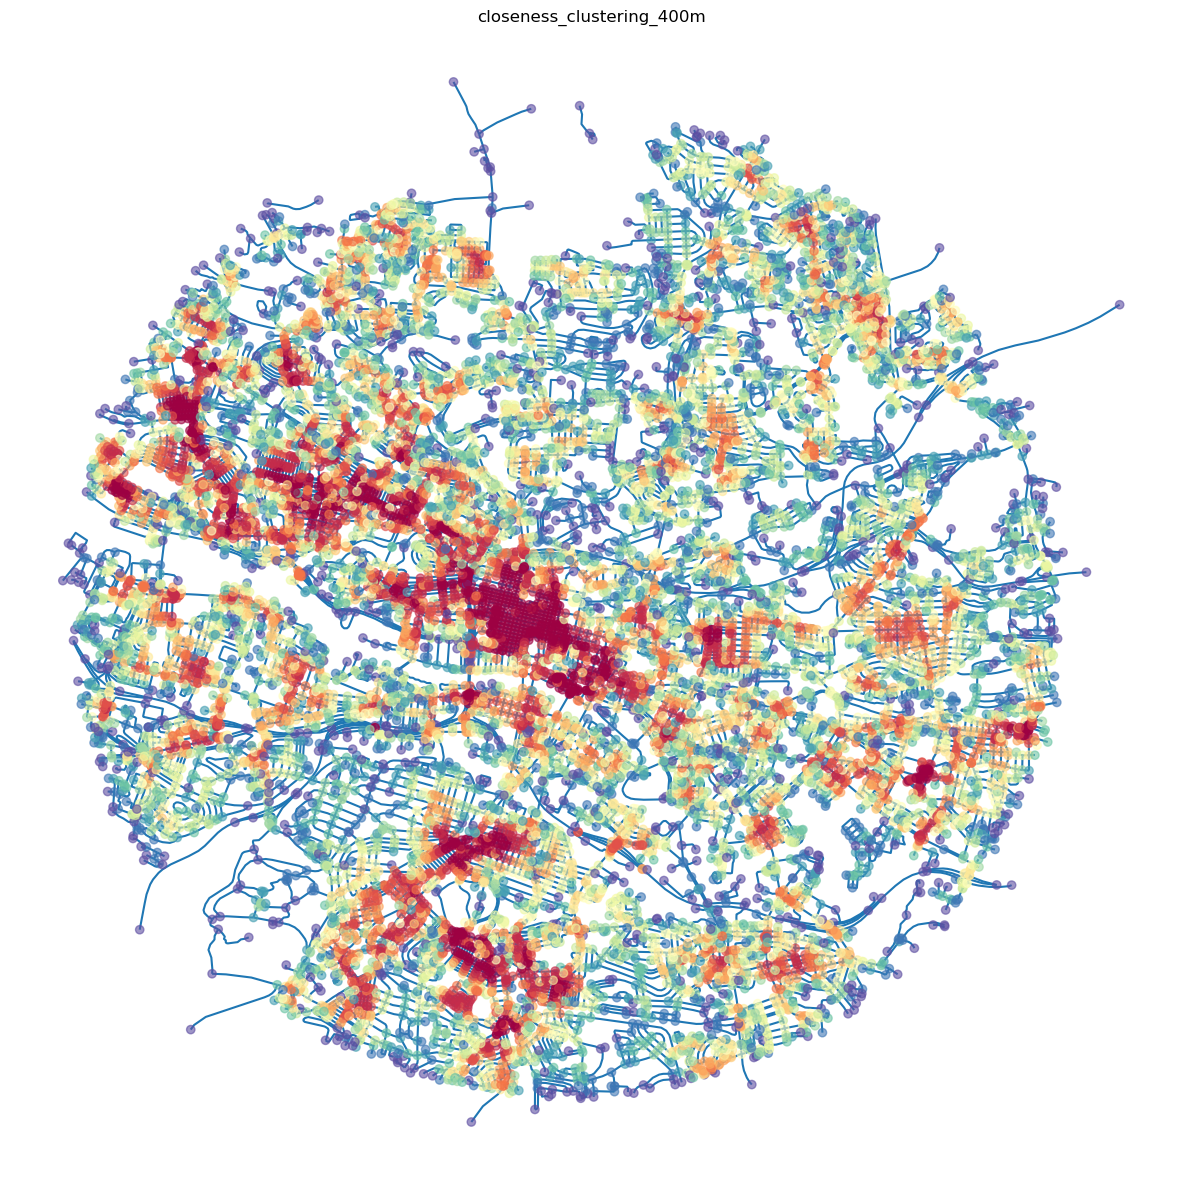

In [ ]:

f, ax = plt.subplots(figsize=(15, 15))
nodes.plot(ax=ax, column="closeness_clustering_400m", cmap='Spectral_r', scheme='quantiles', k=15, alpha=0.6, zorder=1)
edges.plot(ax=ax, zorder=0)
closeness400 = nodes["closeness_clustering_400m"]

ax.set_axis_off()
ax.set_title("closeness_clustering_400m")
plt.show()

#### Global closeness

Global closeness centrality is a bit simpler as we do not have to specify radius and distance, the rest remains the same.

In [ ]:
primal_gdf_points, primal_gdf  = momepy.nx_to_gdf(primal, points=True, lines=True)

In [ ]:
unique_ids = edges[~edges['id'].isin(primal_gdf['id'])]
unique_ids

# Convert unique_ids to a list of IDs if it's still a DataFrame
unique_id_list = unique_ids['id'].tolist()

# Drop entries in nodes where ID is in unique_id_list
edges = edges[~edges['id'].isin(unique_id_list)]

In [ ]:
unique_ids = nodes[~nodes['nodeID'].isin(primal_gdf_points['nodeID'])]
unique_ids

# Convert unique_ids to a list of IDs if it's still a DataFrame
unique_id_list = unique_ids['nodeID'].tolist()

# Drop entries in edges where ID is in unique_id_list
nodes = nodes[~nodes['nodeID'].isin(unique_id_list)]

In [ ]:
primal = momepy.closeness_centrality(primal, name='global_closeness_centrality_primal', weight='mm_len')
n = momepy.nx_to_gdf(primal, lines=False)
nodes['global_closeness_centrality_primal'] = n['global_closeness_centrality_primal']

### Betweenness

Betweenness centrality measures the importance of each node or edge for travelling along the network. It measures how many times each node/edge used if we walk using the shortest paths from each node to every other. 

We have two options of how to measure betweenness on primal graphs - on nodes or on edges.

#### Node-based
Node-based betweenness, as the name suggests, measures the betweenness of each node - how many times we would walk through the node.

In [ ]:
primal = momepy.betweenness_centrality(primal, name='betweenness_metric_n', mode='nodes', weight='mm_len')
n = momepy.nx_to_gdf(primal, lines=False)
nodes['global_betweeness_centrality_vertex']= n['betweenness_metric_n']

2024-01-11 16:23:25,528 - distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)
2024-01-11 16:23:27,648 - distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)


KeyboardInterrupt: 

In [ ]:
f, ax = plt.subplots(figsize=(15, 15))
nodes.plot(ax=ax, column='global_betweeness_centrality_vertex', cmap='Spectral_r', scheme='quantiles', k=15, alpha=0.6, zorder=1)
edges.plot(ax=ax, zorder=0)

ax.set_axis_off()
ax.set_title(label='global_betweeness_centrality_vertex')
plt.show()

#### Edge-based

Edge-based betweenness does the same but for edges: how many times we go through each edge (street).

In [ ]:
primal = momepy.betweenness_centrality(primal, name='betweeness_centrality_edge', mode='edges', weight='mm_len')
n = momepy.nx_to_gdf(primal, lines=False)
nodes['betweeness_centrality_edge']= n['betweeness_centrality_edge']

In [ ]:
f, ax = plt.subplots(figsize=(15, 15))
nodes.plot(ax=ax, column='betweeness_centrality_edge', cmap='Spectral_r', scheme='quantiles', k=15, alpha=0.6, zorder=1)

ax.set_axis_off()
ax.set_title(label='betweeness_centrality_edge')
plt.show()

### Straightness

While both closeness and betweenness are generally used in many applications of network analysis, straightness centrality is specific to street networks as it requires a geographical element. It is measured as a ratio between real and Euclidean distance while waking from each node to every other.

In [ ]:
primal = momepy.straightness_centrality(primal, radius=5)
gdf = momepy.nx_to_gdf(primal, lines=False)

In [ ]:
nodes["global_straightness_centrality"] = gdf["straightness"]

In [ ]:


nodes["straightness_400m"] = gdf["straightness"]

f, ax = plt.subplots(figsize=(15, 15))
nodes.plot(ax=ax, column="straightness_400m", cmap='Spectral_r', scheme='quantiles', k=15, alpha=0.6)

ax.set_axis_off()
ax.set_title("global_straightness_centrality")
plt.show()

### Node values averaged onto edges

In some cases, it is easier to understand centrality results if they are attached to street segments, rather than intersections. We can do an approximation using the mean value attached to start and end node of each edge.

In [ ]:
nodes

In [ ]:
for node in primal.nodes:
    row = nodes[nodes["nodeID"] == primal.nodes[node]["nodeID"]].iloc[0]
    
    columns = row.keys().drop(['nodeID', 'geometry'])
    for column in columns:
        primal.nodes[node][column] = row[column]

In [ ]:
primal.nodes

In [ ]:
momepy.mean_nodes(primal, 'global_straightness_centrality')
momepy.mean_nodes(primal, 'closeness_clustering_400m')
momepy.mean_nodes(primal, 'global_closeness_centrality_primal')
momepy.mean_nodes(primal, 'global_betweeness_centrality_vertex')

In [ ]:
primal_gdf = momepy.nx_to_gdf(primal, points=False)

f, ax = plt.subplots(figsize=(15, 15))
primal_gdf.plot(ax=ax, column='global_straightness_centrality', cmap='Spectral_r', scheme='quantiles', k=15, alpha=0.6)
ax.set_axis_off()
ax.set_title('straightness')
plt.show()

In [ ]:
f, ax = plt.subplots(figsize=(15, 15))
primal_gdf.plot(ax=ax, column='closeness_clustering_400m', cmap='Spectral_r', scheme='quantiles', k=15, alpha=0.6)
ax.set_axis_off()
ax.set_title('closeness400 node based mean')
plt.show()

In [ ]:
f, ax = plt.subplots(figsize=(15, 15))
primal_gdf.plot(ax=ax, column='global_closeness_centrality_primal', cmap='Spectral_r', scheme='quantiles', k=15, alpha=0.6)
ax.set_axis_off()
ax.set_title('closeness global node based mean')
plt.show()

In [ ]:
f, ax = plt.subplots(figsize=(15, 15))
primal_gdf.plot(ax=ax, column='global_betweeness_centrality_vertex', cmap='Spectral_r', scheme='quantiles', k=15, alpha=0.6)
ax.set_axis_off()
ax.set_title('betweennes node based mean')
plt.show()

In [ ]:
edges["global_straightness_centrality"] = primal_gdf["global_straightness_centrality"]
edges["closeness_clustering_400m"] = primal_gdf["closeness_clustering_400m"]
edges["global_closeness_centrality_primal	"] = primal_gdf["global_closeness_centrality_primal"]
edges["global_betweeness_centrality_vertex"] = primal_gdf["global_betweeness_centrality_vertex"]

In [ ]:
edges

Once we have finished our network analysis on the primal graph, we can save both nodes and edges back to GeoDataFrames.

### Topological vs metric distances

Centrality can be measured topologically (ignoring physical lengths of street segments) or metrically. Moreover, in the case of local centrality, local subgraphs can be also defined topologically and metrically. In the end, you have four options of how to measure centralilty, illustrated on `betweenness_centrality`:

```py
# topologically defined subgraph (5 steps) and topologically measured shortest path
betweenness_centrality(graph, radius=5, distance=None, weight=None)

# topologically defined subgraph (5 steps) and metrically measured shortest path
betweenness_centrality(graph, radius=5, distance=None, weight='edge_length')

# metrically defined subgraph (800 meters) and topologically measured shortest path
betweenness_centrality(graph, radius=800, distance='edge_length', weight=None)

# metrically defined subgraph (800 meters) and metrically measured shortest path
betweenness_centrality(graph, radius=800, distance='edge_length', weight='edge_length')
```

## Dual graph

Dual graph is a bit more complicated concept as it represents street segments as nodes with intersections as edges connecting nodes. The geographical distance is lost as edges are of virtually no length, but we can capture the angle between connected streets. Momepy does that by default, using angles between lines connecting the start and end points of each segment. Hence, we can measure angular centrality.

**Note**: Dual graphs have naturally much more connections than primal ones, so computation of centrality on dual graph takes longer.

In [ ]:
edges["id"] = edges.index

In [ ]:
dual = momepy.gdf_to_nx(edges, approach='dual')

/home/virgilxw/miniforge3/envs/processor/lib/python3.12/site-packages/momepy/utils.py:99: FutureWarning: `use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning
  sw = libpysal.weights.Queen.from_dataframe(gdf_network, silence_warnings=True)
2024-01-11 16:27:23,403 - distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)


KeyboardInterrupt: 

In [ ]:
dual_gdf = momepy.nx_to_gdf(dual, points=False)
dual_gdf

In [ ]:
unique_ids = edges[~edges['id'].isin(dual_gdf['id'])]
unique_ids

# Convert unique_ids to a list of IDs if it's still a DataFrame
unique_id_list = unique_ids['id'].tolist()

# Drop entries in edges where ID is in unique_id_list
edges = edges[~edges['id'].isin(unique_id_list)]

### Angular closeness

The situation with closeness is similar to the one done on primal graphs. We can again do global and local closeness.

#### Local
The difference is that we do not have geographic distance, so we can limit closeness topologically or by another attribute (line angle). The example below uses a topological distance of 5 steps.

In [ ]:
closeness_dual = momepy.closeness_centrality(dual, radius=5, name='angular_closeness_order_5', weight='angle')

dual_gdf = momepy.nx_to_gdf(closeness_dual, points=False)


In [ ]:
edges['angular_closeness_order_5'] = dual_gdf['angular_closeness_order_5']

f, ax = plt.subplots(figsize=(15, 15))
dual_gdf.plot(ax=ax, column='angular_closeness_order_5', cmap='Spectral_r', scheme='quantiles', k=15, alpha=0.6)
ax.set_axis_off()
ax.set_title('closeness angular 5')
plt.show()

#### Global

Global angular closeness is then straightforward.

In [ ]:
primal = momepy.closeness_centrality(dual, name='closeness_global_ang', weight='angle')
n = momepy.nx_to_gdf(dual, points=False)
edges['global_angular_closeness']= n['closeness_global_ang']

NameError: name 'dual' is not defined

In [ ]:
f, ax = plt.subplots(figsize=(15, 15))
edges.plot(ax=ax, column='global_angular_closeness', cmap='Spectral_r', scheme='quantiles', k=15, alpha=0.6)
ax.set_axis_off()
ax.set_title('global_angular_closeness')
plt.show()

### Angular betweenness
The last option momepy offers is angular betweenness. Just keep in mind, that nodes and edges are not representing the same concepts and it does not make much sense to measure angular betweenness on edges. Moreover, `nx_to_gdf` converts a dual graph to a LineString gdf only.

In [ ]:
primal = momepy.betweenness_centrality(dual, name='angbetweenness', mode='nodes', weight='angle')
n = momepy.nx_to_gdf(dual, points=False)
edges["global_angular_betweeness"]= n['angbetweenness']

In [ ]:
df, ax = plt.subplots(figsize=(15, 15))
edges.plot(ax=ax, column="global_angular_betweeness", cmap='Spectral_r', scheme='quantiles', k=15, alpha=0.6)
ax.set_axis_off()
ax.set_title('betweenness angular')
plt.show()

In [ ]:
edges = edges.drop(columns=["id"], axis=1)

In [ ]:
nodes

In [ ]:
edges.to_parquet(f"../output/{place}/edges_p4.pq")
nodes.to_parquet(f"../output/{place}/nodes_p4.pq")